In [1]:
import tarfile

# Path to your tar file
tar_path = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar"
extract_path = "/kaggle/working/BraTS2021_Training_Data"

# Open and extract
with tarfile.open(tar_path, "r:") as tar:
    tar.extractall(path=extract_path)

print("Extraction completed! Files are in:", extract_path)

Extraction completed! Files are in: /kaggle/working/BraTS2021_Training_Data


In [2]:
pip install numpy nibabel opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob
import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm

def get_bounding_box(mask_slice):
    """
    Calculates the bounding box coordinates of a 2D segmentation mask.

    Args:
        mask_slice (np.array): A 2D numpy array of the mask.

    Returns:
        tuple: A tuple containing (x_min, y_min, x_max, y_max).
    """
    # Find contours
    contours, _ = cv2.findContours(mask_slice.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None

    # Combine all contours to get a single bounding box
    all_points = np.concatenate(contours, axis=0)
    x_min, y_min, w, h = cv2.boundingRect(all_points)
    x_max = x_min + w
    y_max = y_min + h
    
    return (x_min, y_min, x_max, y_max)

def convert_to_yolo_format(box, img_width, img_height):
    """
    Converts bounding box coordinates to YOLO format.

    Args:
        box (tuple): A tuple (x_min, y_min, x_max, y_max).
        img_width (int): The width of the image.
        img_height (int): The height of the image.

    Returns:
        str: A string in YOLO format "<class_id> <x_center> <y_center> <width> <height>".
    """
    x_min, y_min, x_max, y_max = box
    
    # Calculate center, width, and height
    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0
    width = x_max - x_min
    height = y_max - y_min
    
    # Normalize by image dimensions
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height
    
    # For this task, we have only one class: 'tumor' (class_id = 0)
    class_id = 0
    
    return f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"

def process_brats_dataset(dataset_path, output_path):
    """
    Processes the BraTS 21 dataset to create 2D images and YOLO labels.
    """
    # Create output directories
    os.makedirs(os.path.join(output_path, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels/train'), exist_ok=True)
    
    patient_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    
    print(f"Found {len(patient_folders)} patients. Starting processing...")
    
    for patient_id in tqdm(patient_folders, desc="Processing Patients"):
        patient_folder_path = os.path.join(dataset_path, patient_id)
        
        # We will use the T2-FLAIR scan for the image, as it usually shows the tumor and edema best.
        try:
            flair_path = glob.glob(os.path.join(patient_folder_path, '*_flair.nii.gz'))[0]
            seg_path = glob.glob(os.path.join(patient_folder_path, '*_seg.nii.gz'))[0]
        except IndexError:
            print(f"Warning: Skipping {patient_id} due to missing files.")
            continue

        # Load NIfTI files
        flair_img = nib.load(flair_path).get_fdata()
        seg_mask = nib.load(seg_path).get_fdata()
        
        # Get image dimensions
        _, _, num_slices = flair_img.shape
        img_height, img_width = flair_img.shape[:2]
        
        # Process each slice
        for i in range(num_slices):
            img_slice = flair_img[:, :, i]
            mask_slice = seg_mask[:, :, i]
            
            # We only want to save slices that actually contain a tumor
            if np.sum(mask_slice) > 0:
                # Normalize the image slice to 0-255 and convert to 3-channel grayscale for YOLO models
                img_slice_normalized = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                img_slice_rgb = cv2.cvtColor(img_slice_normalized, cv2.COLOR_GRAY2BGR)

                # Get bounding box from the mask
                bbox = get_bounding_box(mask_slice)
                
                if bbox:
                    # Convert to YOLO format
                    yolo_label = convert_to_yolo_format(bbox, img_width, img_height)
                    
                    # Define file paths
                    base_filename = f"{patient_id}_slice_{i:03d}"
                    image_save_path = os.path.join(output_path, 'images/train', f"{base_filename}.png")
                    label_save_path = os.path.join(output_path, 'labels/train', f"{base_filename}.txt")
                    
                    # Save the image and the label file
                    cv2.imwrite(image_save_path, img_slice_rgb)
                    with open(label_save_path, 'w') as f:
                        f.write(yolo_label)

    print("Processing complete!")
    print(f"Data saved in: {output_path}")

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # DEFINE YOUR PATHS HERE
    # This should be the path to the main folder containing all the 'BraTS2021_xxxxx' folders.
    BRATS_DATASET_PATH = "/kaggle/working/BraTS2021_Training_Data" 
    
    # This is where the 2D images and YOLO labels will be saved.
    YOLO_OUTPUT_PATH = "/kaggle/working/"

    process_brats_dataset(BRATS_DATASET_PATH, YOLO_OUTPUT_PATH)

Found 1251 patients. Starting processing...


Processing Patients: 100%|██████████| 1251/1251 [06:39<00:00,  3.13it/s]

Processing complete!
Data saved in: /kaggle/working/


In [4]:
pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


Displaying 5 random samples...


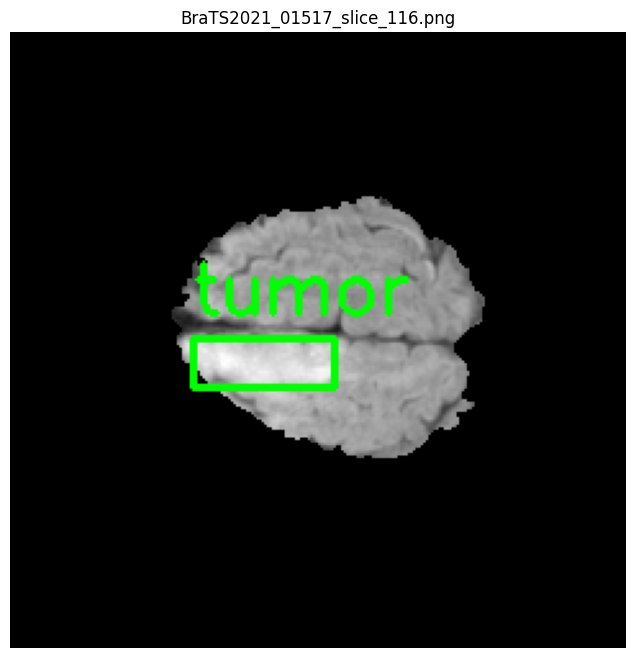

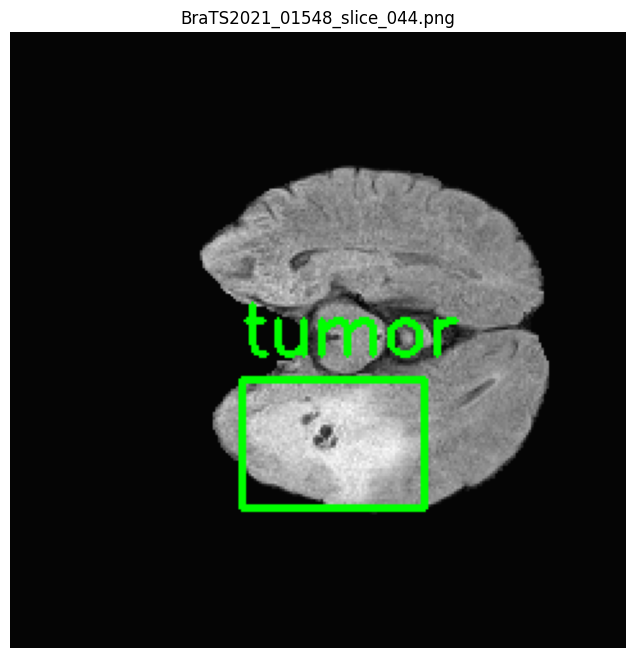

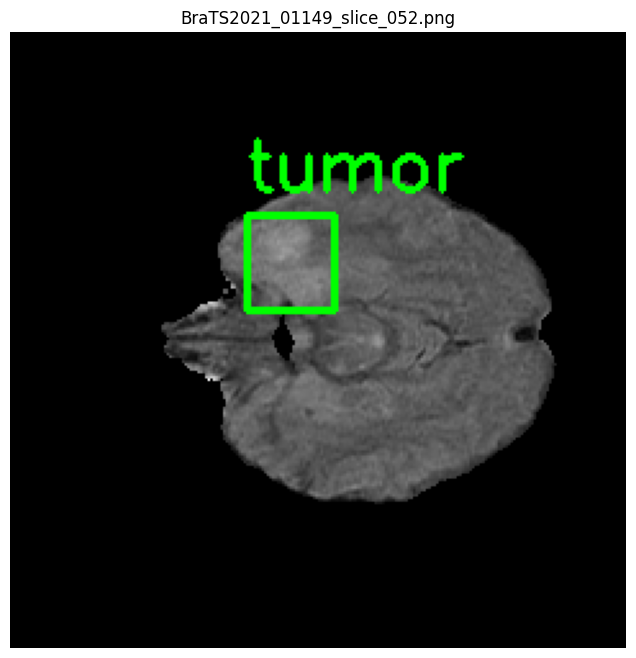

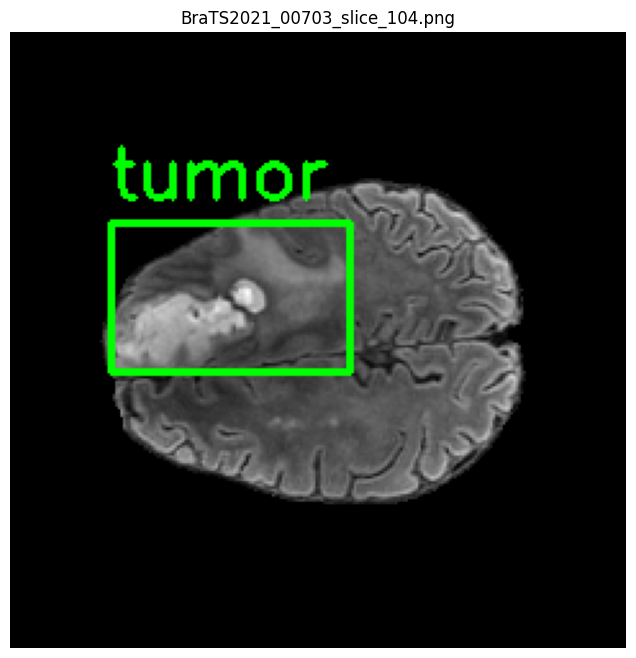

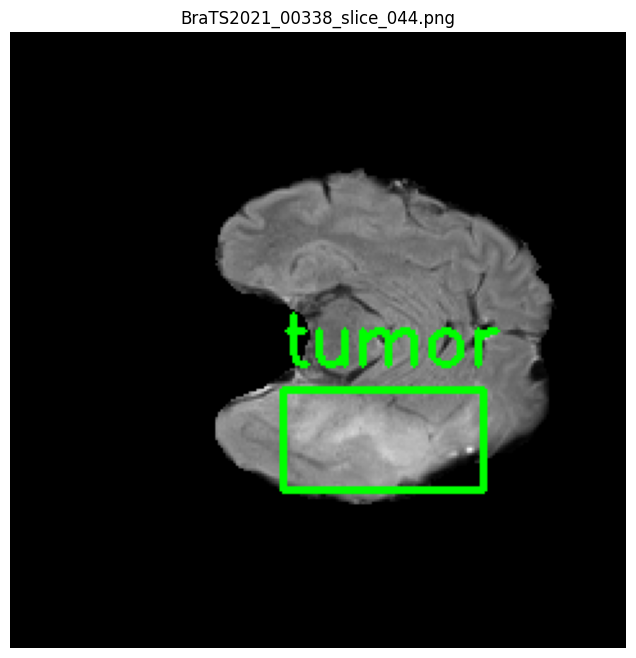

In [5]:
import cv2
import os
import random
import matplotlib.pyplot as plt

def show_yolo_samples(image_dir, label_dir, num_samples=5):
    """
    Loads random samples from a YOLO dataset, draws the bounding boxes,
    and displays them.

    Args:
        image_dir (str): Path to the directory containing images.
        label_dir (str): Path to the directory containing YOLO label files.
        num_samples (int): The number of random samples to display.
    """
    # Get a list of all image files
    all_images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Ensure we don't request more samples than available
    num_samples = min(num_samples, len(all_images))
    
    if num_samples == 0:
        print("Error: No images found in the specified directory.")
        return
        
    # Pick random samples
    random_samples = random.sample(all_images, num_samples)
    
    print(f"Displaying {num_samples} random samples...")

    for image_name in random_samples:
        image_path = os.path.join(image_dir, image_name)
        # Construct the corresponding label file path
        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(label_dir, label_name)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image {image_path}")
            continue
            
        h, w, _ = image.shape

        # Check if the label file exists
        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {image_name}")
            continue

        # Read the label file
        with open(label_path, 'r') as f:
            line = f.readline()
            if not line:
                continue

            # Parse the YOLO format: class_id x_center y_center width height
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center_norm = float(parts[1])
            y_center_norm = float(parts[2])
            width_norm = float(parts[3])
            height_norm = float(parts[4])

            # De-normalize the coordinates
            box_w = width_norm * w
            box_h = height_norm * h
            x_center = x_center_norm * w
            y_center = y_center_norm * h

            # Calculate top-left corner coordinates (x_min, y_min)
            x_min = int(x_center - (box_w / 2))
            y_min = int(y_center - (box_h / 2))
            x_max = int(x_center + (box_w / 2))
            y_max = int(y_center + (box_h / 2))

            # Draw the bounding box
            # Green color (0, 255, 0) with a thickness of 2
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            
            # Add the class label text
            # The class name is 'tumor' since class_id is 0
            label_text = "tumor"
            cv2.putText(image, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Convert BGR image (from OpenCV) to RGB for Matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.title(image_name)
        plt.axis('off')
        plt.show()

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # DEFINE THE PATH TO YOUR YOLO DATASET
    YOLO_DATASET_PATH = "/kaggle/working/"

    # Define the specific folders for images and labels
    IMAGE_DIRECTORY = os.path.join(YOLO_DATASET_PATH, 'images/train')
    LABEL_DIRECTORY = os.path.join(YOLO_DATASET_PATH, 'labels/train')

    # Call the function to show the samples
    show_yolo_samples(IMAGE_DIRECTORY, LABEL_DIRECTORY, num_samples=5)

In [6]:
import os
import glob
import random
import shutil
from tqdm import tqdm

def create_validation_split(dataset_path, split_ratio=0.2):
    """
    Splits the dataset into training and validation sets based on patient IDs.

    Args:
        dataset_path (str): The root path of the YOLO dataset.
        split_ratio (float): The percentage of patients to move to the validation set.
    """
    # Define paths
    train_images_path = os.path.join(dataset_path, 'images/train')
    train_labels_path = os.path.join(dataset_path, 'labels/train')
    val_images_path = os.path.join(dataset_path, 'images/val')
    val_labels_path = os.path.join(dataset_path, 'labels/val')

    # 1. Create validation directories if they don't exist
    os.makedirs(val_images_path, exist_ok=True)
    os.makedirs(val_labels_path, exist_ok=True)
    print("📁 Created 'val' directories.")

    # 2. Get a unique list of all patient IDs from the filenames
    all_files = os.listdir(train_images_path)
    # Assumes filename format is 'BraTS2021_xxxxx_slice_yyy.png'
    patient_ids = sorted(list(set([f.split('_slice_')[0] for f in all_files])))
    
    if not patient_ids:
        print("❌ Error: No patient files found in the training directory.")
        return

    print(f"Found {len(patient_ids)} unique patients.")

    # 3. Shuffle the patient IDs and select a portion for validation
    random.shuffle(patient_ids)
    split_index = int(len(patient_ids) * split_ratio)
    val_patients = patient_ids[:split_index]
    
    print(f"Moving {len(val_patients)} patients to the validation set...")

    # 4. Move the files for the selected validation patients
    for patient_id in tqdm(val_patients, desc="Moving files"):
        # Find all images for this patient
        image_files_to_move = glob.glob(os.path.join(train_images_path, f'{patient_id}*.png'))
        # Find all labels for this patient
        label_files_to_move = glob.glob(os.path.join(train_labels_path, f'{patient_id}*.txt'))
        
        # Move each image file
        for file_path in image_files_to_move:
            shutil.move(file_path, val_images_path)
            
        # Move each label file
        for file_path in label_files_to_move:
            shutil.move(file_path, val_labels_path)

    print("\n✅ Dataset split complete!")
    print(f"   Training set size: {len(os.listdir(train_images_path))} images")
    print(f"   Validation set size: {len(os.listdir(val_images_path))} images")


# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # 1. DEFINE THE PATH TO YOUR YOLO DATASET
    YOLO_DATASET_PATH = "/kaggle/working/"

    # 2. DEFINE THE SPLIT RATIO (0.2 means 20% for validation)
    VALIDATION_SPLIT_RATIO = 0.2

    create_validation_split(YOLO_DATASET_PATH, VALIDATION_SPLIT_RATIO)

📁 Created 'val' directories.
Found 1251 unique patients.
Moving 250 patients to the validation set...


Moving files: 100%|██████████| 250/250 [00:34<00:00,  7.25it/s]


✅ Dataset split complete!
   Training set size: 65510 images
   Validation set size: 15927 images


In [7]:
import yaml
import os

# --- CONFIGURE YOUR PATH HERE ---
# Enter the absolute path to the main folder of your YOLO dataset.
# This is the folder that contains the 'images' and 'labels' subdirectories.
dataset_base_path = '/kaggle/working/'

# --- THE SCRIPT WILL DO THE REST ---

# Define the data structure for the YAML file
# The paths will be absolute, which is robust for most YOLO implementations.
data_yaml_structure = {
    'train': os.path.join(dataset_base_path, 'images/train'),
    'val': os.path.join(dataset_base_path, 'images/val'),
    'nc': 1,
    'names': ['tumor']
}

# Define where the data.yaml file will be saved
yaml_file_path = os.path.join(dataset_base_path, 'data.yaml')

# Write the data to the YAML file
try:
    with open(yaml_file_path, 'w') as f:
        yaml.dump(data_yaml_structure, f, default_flow_style=False, sort_keys=False)
    
    print(f"✅ 'data.yaml' file created successfully!")
    print(f"   Location: {yaml_file_path}")
    print("\n--- File Content ---")
    # Print the content to the console for verification
    print(yaml.dump(data_yaml_structure, default_flow_style=False, sort_keys=False))

except Exception as e:
    print(f"❌ An error occurred while creating the file: {e}")

✅ 'data.yaml' file created successfully!
   Location: /kaggle/working/data.yaml

--- File Content ---
train: /kaggle/working/images/train
val: /kaggle/working/images/val
nc: 1
names:
- tumor



In [8]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: nvidi

In [10]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolov8n")

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="/kaggle/working/data.yaml", epochs=10, imgsz=640)


Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      15927      15927      0.915       0.82      0.896      0.672
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2
